Adınız: Muhammed Mert

Soyadınız: Sayan

Okul No: 2212721028

GitHub Repo Bağlantısı: https://github.com/MertSayan/CNN_siniflandirma

In [ ]:
#drive a bağlanıyorum (izin falan veriyorum)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#drivedaki dosya yolumu buraya tanırıyorum ve içeirsinde kaç veri olduğunu bastırıyorum
import os

base_path = '/content/drive/MyDrive/CNN_Dis_Odevi/dataset'

print("Diş fırçası:", len(os.listdir(base_path + '/dis_fircasi')))
print("Diş macunu:", len(os.listdir(base_path + '/dis_macunu')))

Diş fırçası: 77
Diş macunu: 67


In [ ]:
#pixel değerleri büyük olan veri setimi 128x128 olarak yeniden boyutlandırarak drive da dataset_128 klasörü altında klasörledim.
from PIL import Image
import os

# Giriş ve çıkış klasörleri
input_base = "/content/drive/MyDrive/CNN_Dis_Odevi/dataset"
output_base = "/content/drive/MyDrive/CNN_Dis_Odevi/dataset_128"

classes = ["dis_fircasi", "dis_macunu"]
target_size = (128, 128)

os.makedirs(output_base, exist_ok=True)

for cls in classes:
    input_dir = os.path.join(input_base, cls)
    output_dir = os.path.join(output_base, cls)
    os.makedirs(output_dir, exist_ok=True)

    count = 0
    for file in os.listdir(input_dir):
        if file.lower().endswith((".jpg", ".jpeg", ".png")):
            try:
                img_path = os.path.join(input_dir, file)
                img = Image.open(img_path).convert("RGB")
                img = img.resize(target_size)
                img.save(os.path.join(output_dir, file))
                count += 1
            except Exception as e:
                print(f"Hata: {file} -> {e}")

    print(f"{cls}: {count} görsel 128x128 olarak kaydedildi.")

dis_fircasi: 77 görsel 128x128 olarak kaydedildi.
dis_macunu: 67 görsel 128x128 olarak kaydedildi.


In [ ]:
#128x128 olarak hazırladığım veri setindeki görsellerin isimlerini düzenliyorum
import os

base_path = "/content/drive/MyDrive/CNN_Dis_Odevi/dataset_128"
classes = ["dis_fircasi", "dis_macunu"]

for cls in classes:
    folder_path = os.path.join(base_path, cls)
    files = sorted([
        f for f in os.listdir(folder_path)
        if f.lower().endswith((".jpg", ".jpeg", ".png"))
    ])

    for i, file in enumerate(files, start=1):
        old_path = os.path.join(folder_path, file)
        new_name = f"img_{i:03d}.jpg"
        new_path = os.path.join(folder_path, new_name)

        if old_path != new_path:
            os.rename(old_path, new_path)

    print(f"{cls}: {len(files)} görsel yeniden adlandırıldı.")

dis_fircasi: 77 görsel yeniden adlandırıldı.
dis_macunu: 67 görsel yeniden adlandırıldı.


Model1 aşamasında VGG16 mimarisini ImageNet ağırlıklarıyla kullanacağım.
Sıfırdan eğitmek yerine transfer learning uygulayacağım.
Önce konvolüsyon katmanlarını dondurarak feature extractor olarak kullanacağım, ardından üst katmanlarda fine-tuning yapacağım.

**Ama önce veri setimi train-validation-test olarak ayıralım**

In [ ]:
#veri setini eğitim-doğrulama-test olarak ayırdım.
import os
import shutil
import random

# Kaynak dataset (128x128 boyutlu gorseller)
source_dir = "/content/drive/MyDrive/CNN_Dis_Odevi/dataset_128"

# Hedef dizin
base_dir = "/content/drive/MyDrive/CNN_Dis_Odevi/dataset_split"

classes = ["dis_fircasi", "dis_macunu"]

splits = {
    "train": 0.7,
    "val": 0.15,
    "test": 0.15
}

# Klasörleri oluştur
for split in splits:
    for cls in classes:
        os.makedirs(os.path.join(base_dir, split, cls), exist_ok=True)

# Dosyaları böl
for cls in classes:
    files = os.listdir(os.path.join(source_dir, cls))
    random.shuffle(files)

    total = len(files)
    train_end = int(total * splits["train"])
    val_end = train_end + int(total * splits["val"])

    split_files = {
        "train": files[:train_end],
        "val": files[train_end:val_end],
        "test": files[val_end:]
    }

    for split, split_list in split_files.items():
        for file in split_list:
            src = os.path.join(source_dir, cls, file)
            dst = os.path.join(base_dir, split, cls, file)
            shutil.copy(src, dst)

    print(f"{cls} → Train:{len(split_files['train'])} | Val:{len(split_files['val'])} | Test:{len(split_files['test'])}")


dis_fircasi → Train:53 | Val:11 | Test:13
dis_macunu → Train:46 | Val:10 | Test:11


In [ ]:
# Bu projede Keras kütüphanesini kullanarak görüntüleri modele okutuyorum.


from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Dataset'in train/val/test olarak ayrıldığı ana klasör yolu
base_dir = "/content/drive/MyDrive/CNN_Dis_Odevi/dataset_split"

# Tüm görüntülerimi daha önce 128x128 boyutuna getirdiğim için model giriş boyutunu da 128x128 olarak belirliyorum
IMG_SIZE = (128, 128)

# Küçük veri setlerinde yaygın olarak kullanılan batch size
BATCH_SIZE = 32

# Model1 aşamasında veri artırımı (augmentation) uygulamıyorum.
# Sadece piksel değerlerini [0,1] aralığına çekmek için rescale yapıyorum.
  #Görüntülerin piksel değerleri (0-255 aralığında) rescale=1./255 komutu ile 0-1 aralığına normalize edilir.
    #Bu işlem, derin öğrenme modelinin daha hızlı, daha kararlı ve daha verimli bir şekilde öğrenmesini sağlamak
      # için kritik bir ön işlemdir. Büyük sayısal değerlerin (0-255) modelin optimizasyon sürecinde dengesizlik yaratmasını önler.
# Veri artırımı model3 aşamasında kullanılacaktır.
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen   = ImageDataGenerator(rescale=1./255)
test_datagen  = ImageDataGenerator(rescale=1./255)

# Eğitim verilerini Keras'a okutuyorum
# Klasör isimleri otomatik olarak sınıf etiketi olarak alınır
train_generator = train_datagen.flow_from_directory(
    directory=f"{base_dir}/train",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

# Doğrulama (validation) verilerini okutuyorum
# Bu veri eğitim sırasında overfitting kontrolü için kullanılır
val_generator = val_datagen.flow_from_directory(
    directory=f"{base_dir}/val",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

# Test verilerini okutuyorum
# shuffle=False kullanarak test sonuçlarının sırasını koruyorum
  # Bu sayede confusion matrix ve classification report doğru hesaplanabilir
    #Test verisi okunurken shuffle=False kullanılması, görüntülerin modelden geçtiği sıranın korunmasını sağlar.
      #Bu sabitleme, modelin yaptığı tahminler (Y_pred) ile görüntülerin doğru etiketlerinin (Y_true) birebir aynı sırayla eşleşmesini garanti eder.
        #Bu eşleşme, Confusion Matrix ve Classification Report gibi kritik model değerlendirme metriklerinin hatasız hesaplanabilmesi için mutlaka gereklidir.
test_generator = test_datagen.flow_from_directory(
    directory=f"{base_dir}/test",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

Found 99 images belonging to 2 classes.
Found 21 images belonging to 2 classes.
Found 24 images belonging to 2 classes.


In [ ]:
# VGG16 mimarisini ImageNet ağırlıklarıyla yüklüyorum.
# include_top=False diyerek, ImageNet'e ait sınıflandırıcı katmanları çıkartıyorum.
# Çünkü benim problemim 2 sınıflı (diş fırçası / diş macunu).

from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout

# VGG16 temel modeli
base_model = VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(128, 128, 3)
)

# Transfer learning kapsamında,
# önceden öğrenilmiş konvolüsyon katmanlarını donduruyorum.
  #Transfer Öğrenme stratejisinin bir parçası olarak, VGG16 mimarisinin ImageNet'te öğrenilmiş konvolüsyonel katmanları dondurulur.
    #Amaç: Önceden öğrenilmiş olan genel görsel özelliklerin (kenarlar, dokular) korunması ve küçük veri setimizle (diş fırçası/macunu) eğitim yapılırken bu bilgilerin bozulmasını önlemektir.
for layer in base_model.layers:
    layer.trainable = False

# VGG16'nın çıkışına kendi sınıflandırıcı katmanlarımı ekliyorum
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
output = Dense(2, activation="softmax")(x)

# Son model
model = Model(inputs=base_model.input, outputs=output)

# Model özetini yazdırıyorum
model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,812,610 (64.14 MB)

 Trainable params: 2,097,922 (8.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
# Modeli derliyorum.
# Loss olarak categorical_crossentropy kullanıyorum çünkü
# softmax çıkışlı ve 2 sınıflı bir problemim var o yüzden categorical_crossentropy kullanıyorum.
# Optimizer olarak Adam seçiyorum.
# Accuracy metriğini takip ediyorum.

model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [ ]:
# Modeli eğitiyorum.
# Train verisi ile öğrenme yapılacak,
# validation verisi ile her epoch sonunda doğrulama yapılacak.
# history değişkeni eğitim sürecindeki accuracy ve loss değerlerini tutacak.
#epochs u 10 seçmemin sebebi diğer türlü verimin çok fazla olmaması.

history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.5412 - loss: 1.8183 - val_accuracy: 0.8571 - val_loss: 0.3083
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 0.6981 - loss: 0.9577 - val_accuracy: 0.5238 - val_loss: 1.1890
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.7383 - loss: 0.5543 - val_accuracy: 0.8571 - val_loss: 0.2553
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.8123 - loss: 0.3413 - val_accuracy: 0.9048 - val_loss: 0.2046
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 0.9041 - loss: 0.2402 - val_accuracy: 0.9524 - val_loss: 0.1171
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.9310 - loss: 0.1438 - val_accuracy: 0.9524 - val_loss: 0.0858
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.9271 - loss: 0.2616 - val_accuracy: 0.9524 - val_loss: 0.1668
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.9071 - loss: 0.2224 - val_accuracy: 0.9524 - val_loss: 0

# EĞİTİM ÇIKTISININ YORUMU

Train Accuracy: ≈ 0.90

Validation Accuracy: ≈ 0.95

Validation Loss: çok düşük (~0.09)

  Bu şu anlama geliyor:

Model veriyi ezberlememiş (val accuracy yüksek, loss düşük)

Transfer learning çok iyi çalışmış

Dataset’in (diş fırçası / diş macunu) ImageNet’e benzer görsel yapısı var

Yani:
Transfer learning kullandığımız için az veriyle bile yüksek doğruluk elde ettik. VGG16’nın ImageNet’te öğrendiği kenar, şekil ve doku bilgileri bizim problemimize iyi genellendi.

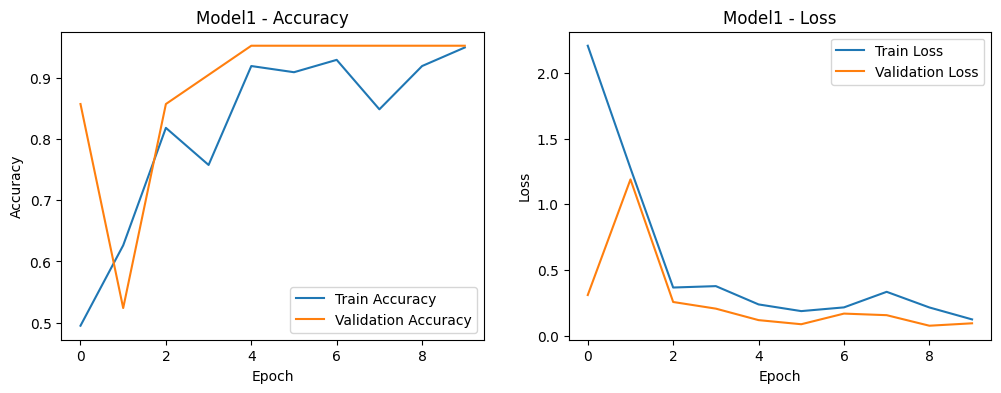

In [ ]:
import matplotlib.pyplot as plt

# Eğitim ve doğrulama accuracy değerleri
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model1 - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Eğitim ve doğrulama loss değerleri
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model1 - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

#Accuracy grafiğinde eğitim ve doğrulama doğruluklarının birlikte yükseldiğini görüyoruz. Bu, modelin aşırı öğrenme yapmadığını gösteriyor.
  #Loss grafiğinde ise hem eğitim hem doğrulama kaybı düzenli olarak azalmış. Bu nedenle Model1, transfer learning yaklaşımıyla başarılı şekilde eğitilmiştir.

# **Accuracy grafiği (soldaki)**

Train accuracy zamanla artıyor → model öğreniyor

Validation accuracy hızlıca %95 civarına çıkıyor ve sabitleniyor


Validation accuracy, train accuracy’den kopmamış

Yani overfitting yok

Model genelleme yapabiliyor

# **Loss grafiği (sağdaki)**

Train loss düzenli düşüyor

Validation loss da aynı şekilde düşüyor ve düşük kalıyor

Bu da şunu gösterir:

Model sadece ezberlemiyor

**Öğrenme sağlıklı**

Eğitim kararlı

In [ ]:
# Test seti üzerinde model performansını ölçüyorum
test_loss, test_accuracy = model.evaluate(test_generator)

print(f"Model1 Test Accuracy: {test_accuracy:.4f}")
print(f"Model1 Test Loss: {test_loss:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.9167 - loss: 0.1680
Model1 Test Accuracy: 0.9167
Model1 Test Loss: 0.1680


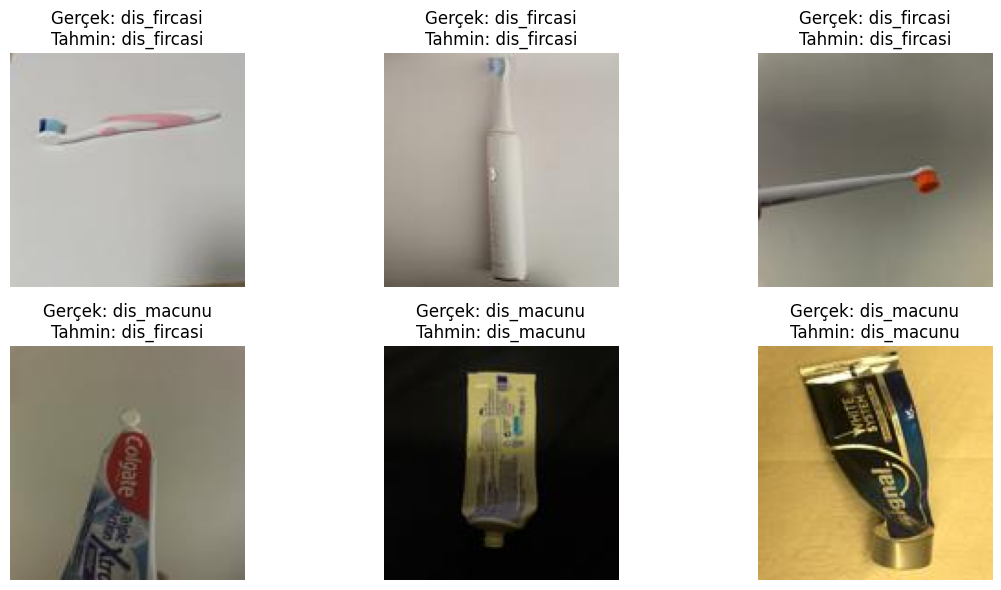

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Sınıf isimlerini alıyorum (klasör isimleri)
class_names = list(test_generator.class_indices.keys())

# Test klasöründen rastgele 6 görsel seçiyorum
test_images = []
test_labels = []

for class_name in class_names:
    class_path = test_generator.directory + '/' + class_name
    images = os.listdir(class_path)
    selected = random.sample(images, min(3, len(images)))  # her sınıftan 3 görsel
    for img_name in selected:
        test_images.append(class_path + '/' + img_name)
        test_labels.append(class_name)

plt.figure(figsize=(12, 6))

for i, img_path in enumerate(test_images):
    img = load_img(img_path, target_size=(128, 128))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array, verbose=0)
    predicted_class = class_names[np.argmax(prediction)]

    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.title(f"Gerçek: {test_labels[i]}\nTahmin: {predicted_class}")
    plt.axis('off')

plt.tight_layout()
plt.show()

# **YORUMLARIM**

# 1. Hangi model neden daha iyi sonuç verdi?
Yaptığım deneyler sonucunda en yüksek doğruluğu %91.67 ile Model 1 (Transfer Learning - VGG16), ardından %87.50 ile Model 3, en düşük doğruluğu ise %79.17 ile Model 2 vermiştir.

Neden Model 1 en iyisi? "Çünkü Model 1'de kullandığım VGG16 mimarisi, ImageNet  kapsamında milyonlarca görselle eğitilmiş devasa bir modeldir. Benim veri setimdeki 'diş fırçası' ve 'diş macunu' gibi objeler, ImageNet veri setindeki ev eşyalarıyla yapısal benzerlik gösterdiği için, modelin önceden öğrendiği kenar, köşe ve doku bilgileri (feature extraction) doğrudan işime yaradı. Benim sınırlı verimle sıfırdan öğrenmek yerine, 'bilen bir modele' sadece son kararı verdirdim.

# 2. Transfer learning (Model 1) neden avantaj/dezavantaj sağladı?
Avantajları:

Küçük Veri Seti Sorunu: Elimdeki veri seti derin bir ağı sıfırdan eğitmek için nispeten azdı. Transfer Learning, az veriyle bile yüksek genelleme başarısı sağladı ve overfitting'e düşmeden %91.67 gibi yüksek bir skora ulaştı.

Hız: Modelin konvolüsyon katmanlarını dondurduğum (freeze) için, sadece son katmanları eğittim. Bu da eğitimin çok daha hızlı tamamlanmasını sağladı.

Dezavantajları:

Model Boyutu: VGG16 parametre sayısı bakımından çok büyük bir modeldir (yaklaşık 138 milyon parametre). Basit bir sınıflandırma işi için hesaplama maliyeti (computational cost), benim kurduğum Model 3'e göre çok daha fazladır. Mobil bir uygulamada çalışacak olsaydı Model 3 daha verimli olabilirdi.

# 3. Model 3'te yapılan hiperparametre değişikliklerinin etkisi ne oldu?
Model 2'den Model 3'e geçerken yaptığım değişiklikler doğruluğu %8 civarında (%79 -> %87) artırdı. Değişikliklerin etkileri şunlardır:

Filtre Sayısını Artırma (32-64 -> 32-64-128): Modelin kapasitesini artırarak daha karmaşık özellikleri öğrenmesini sağladı.

Data Augmentation (Veri Artırımı): Eğitim setindeki görselleri döndürerek ve kaydırarak (rotation, shift) veri setini sanal olarak çeşitlendirdim. Bu, modelin ezberlemesini (overfitting) zorlaştırdı ve gerçek dünya verilerine daha iyi tepki vermesini sağladı.

Kademeli Dropout: Sadece sonda değil, ara katmanlarda da dropout (0.1, 0.2) kullanarak nöronların birbirine aşırı bağımlı olmasını engelledim.

# 4. Model 3, Model 2'den neden daha iyi (ya da kötü) oldu?
Model 3, Model 2'den belirgin şekilde daha iyi sonuç verdi (%87.50 vs %79.17). Bunun temel nedeni Model 2'nin sığ (shallow) kalması ve veriyi ezberlemeye meyilli olmasıdır.

Model 2'de veri artırımı yoktu ve model sürekli aynı pikselleri görüyordu. Model 3 ise her epoch'ta verinin değiştirilmiş halini gördüğü için 'diş fırçasının şeklini' öğrenmek zorunda kaldı, sadece piksel yerlerini ezberleyemedi. Ayrıca Model 3'ün daha derin (3 bloklu) olması, nesneleri ayırt edici ince detayları yakalamasına olanak tanıdı.